<a href="https://colab.research.google.com/github/sonalshreya25/DeepLearning/blob/main/Resnet4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5 : Resnet Transfer Learning

### In this assignment, we are going to study the transfer learning process that uses the pretrained CNN models like ResNet for multi-class image classification.


In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import wandb


# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# set repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)     # Set a random seed for CUDA operations.
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.

    # Ensure deterministic behavior for CUDA operations (note: If you are not concerned with reportable reproducibility, set deterministic to false, and benchmark to true - as it can choose faster algorithms).
    torch.backends.cudnn.deterministic = True  # Set cuDNN to deterministic mode - it will now only select algorithms that are known to be deterministic.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking - it may select the best algorithms for the hardware, but it doesn't guarantee deterministic results.

Using device: cuda:0


In [2]:
# Initialize Weights & Biases
wandb.init(entity="usf-alpha-neurons",project="resnet_transfer_learning")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sonalshreya (usf-alpha-neurons) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Dataset Overview
The Food-101 dataset contains 101,000 images divided into 101 classes. Each class has 750 training images and 250 test images. The dataset is well-suited for deep learning applications due to its large size and diversity.
* 	All images in the Food-101 dataset are of size [128 x 128 pixels].
* 	They are RGB images with three color channels (red, green, blue).
* 	Loaded data: 75750 training images, 25250 test images


### Dataset Preprocessing
*	Resize (224x224): Resizes images to 224x224 pixels to match the input size expected by ResNet models.
*	Random Horizontal Flip: Randomly flips images horizontally for data augmentation, helping the model generalize better.
*	Random Rotation (15 degrees): Rotates images by up to 15 degrees to make the model invariant to slight image rotations.
*	To Tensor & Normalize: Converts images to PyTorch tensors and normalizes pixel values based on ImageNet’s mean and standard deviation to match the pre-trained model's training conditions.


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import wandb


# Define transformations for training and testing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the Food-101 dataset
trainset = torchvision.datasets.Food101(
    root='./data',
    split="train",
    download=True,
    transform=transform_train
)

testset = torchvision.datasets.Food101(
    root='./data',
    split="test",
    download=True,
    transform=transform_test
)

# Create Data Loaders
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Get class names
classes = trainset.classes  # List of 101 food categories

# Log dataset info to Weights & Biases
wandb.config.update({
    "dataset": "Food-101",
    "num_classes": len(classes),
    "train_size": len(trainset),
    "test_size": len(testset),
    "batch_size": 32
})

print(f"Loaded Food-101 dataset with {len(trainset)} training and {len(testset)} test images.")


100%|██████████| 5.00G/5.00G [00:47<00:00, 106MB/s] 


Loaded Food-101 dataset with 75750 training and 25250 test images.


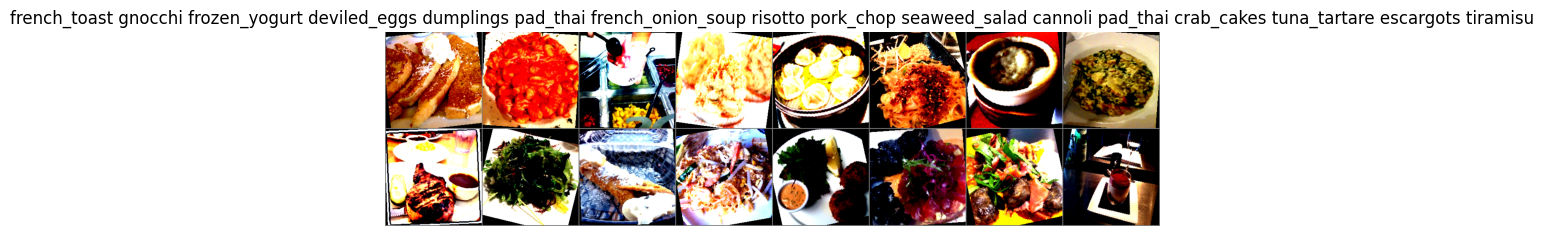

In [5]:
# Function to show images
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create grid of images
img_grid = torchvision.utils.make_grid(images[:16])

# Show images
plt.figure(figsize=(10, 5))
imshow(img_grid)
plt.title(' '.join('%5s' % classes[labels[j]] for j in range(16)))
plt.show()

# Log images to W&B
wandb.log({"sample_images": [wandb.Image(images[i], caption=classes[labels[i]])
                            for i in range(16)]})

We initially experimented with ResNet-34, training it for 10 epochs, which resulted in an accuracy of 49%.
*	Batch Size: 32 (reduced to 16 for fine-tuning to avoid memory issues).
*	Epochs: 10 (initial training) + 5 (fine-tuning) for ResNet-34, then repeated for ResNet-50.
*	Loss Function: Cross-Entropy Loss.
*	Optimizer: Adam.
*	Evaluation Metrics: Accuracy, F1-score (macro), Confusion Matrix.
*	Logging with Weights & Biases (W&B) for experiment tracking and visualization.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = trainset.classes
num_classes = len(classes)
# Load ResNet-34 model
model = models.resnet34(pretrained=True)

# Freeze all layers except the final classification layer
for param in model.parameters():
    param.requires_grad = False

# Modify final layer for Food-101 classification
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(trainloader)
    train_f1 = f1_score(y_true, y_pred, average='macro')

    # Log training metrics
    wandb.log({"epoch": epoch + 1, "train_loss": avg_loss, "train_accuracy": train_acc, "train_f1": train_f1})

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%, F1-score: {train_f1:.4f}")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 169MB/s]


Epoch [1/10] - Loss: 2.7193, Accuracy: 36.11%, F1-score: 0.3517
Epoch [2/10] - Loss: 2.2309, Accuracy: 45.15%, F1-score: 0.4449
Epoch [3/10] - Loss: 2.1584, Accuracy: 46.68%, F1-score: 0.4611
Epoch [4/10] - Loss: 2.1146, Accuracy: 47.68%, F1-score: 0.4712
Epoch [5/10] - Loss: 2.0895, Accuracy: 48.13%, F1-score: 0.4760
Epoch [6/10] - Loss: 2.0660, Accuracy: 48.68%, F1-score: 0.4817
Epoch [7/10] - Loss: 2.0523, Accuracy: 49.00%, F1-score: 0.4846
Epoch [8/10] - Loss: 2.0388, Accuracy: 49.29%, F1-score: 0.4878
Epoch [9/10] - Loss: 2.0329, Accuracy: 49.48%, F1-score: 0.4897
Epoch [10/10] - Loss: 2.0179, Accuracy: 49.86%, F1-score: 0.4936


In [ ]:
# Evaluate on Test Set
import seaborn as sns
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc = accuracy_score(y_true, y_pred) * 100
test_f1 = f1_score(y_true, y_pred, average='macro')

# Log test metrics
wandb.log({"test_accuracy": test_acc, "test_f1": test_f1})
print(f"Test Accuracy: {test_acc:.2f}%, Test F1-score: {test_f1:.4f}")

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Log confusion matrix to W&B
wandb.log({"confusion_matrix": wandb.Image(fig)})
plt.close(fig)

# Fine-Tuning: Unfreeze More Layers
for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower LR for fine-tuning
wandb.config.update({"fine_tuning": True, "learning_rate": 0.0001})



Test Accuracy: 53.01%, Test F1-score: 0.5239


The initial model gave us only a test accuracy of 53%. To enhance performance, we fine-tuned it by unfreezing additional layers and training for 5 more epochs, achieving the following results:

* Fine-Tune Epoch [5/5]
*  Loss: 0.7794
* Accuracy: 77.95%
*  F1-score: 0.7787


In [ ]:
# Fine-tune for 5 more epochs
for epoch in range(5):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    fine_tune_acc = 100 * correct / total
    fine_tune_loss = running_loss / len(trainloader)
    fine_tune_f1 = f1_score(y_true, y_pred, average='macro')

    # Log fine-tuning metrics
    wandb.log({"epoch": epoch + 1 + num_epochs, "fine_tune_loss": fine_tune_loss, "fine_tune_accuracy": fine_tune_acc, "fine_tune_f1": fine_tune_f1})

    print(f"Fine-tune Epoch [{epoch+1}/5] - Loss: {fine_tune_loss:.4f}, Accuracy: {fine_tune_acc:.2f}%, F1-score: {fine_tune_f1:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "resnet34_food101_finetuned.pth")
artifact = wandb.Artifact(name="resnet_transfer_learning", type="model")
artifact.add_file("resnet34_food101_finetuned.pth")

# Log the artifact to W&B
wandb.log_artifact(artifact)
wandb.finish()


Fine-tune Epoch [1/5] - Loss: 1.6701, Accuracy: 57.17%, F1-score: 0.5681
Fine-tune Epoch [2/5] - Loss: 1.2762, Accuracy: 66.27%, F1-score: 0.6605
Fine-tune Epoch [3/5] - Loss: 1.0796, Accuracy: 70.73%, F1-score: 0.7055
Fine-tune Epoch [4/5] - Loss: 0.9180, Accuracy: 74.60%, F1-score: 0.7448
Fine-tune Epoch [5/5] - Loss: 0.7794, Accuracy: 77.95%, F1-score: 0.7787


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
fine_tune_accuracy,▁▄▆▇█
fine_tune_f1,▁▄▆▇█
fine_tune_loss,█▅▃▂▁
test_accuracy,▁
test_f1,▁
train_accuracy,▁▆▆▇▇▇████
train_f1,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
epoch,15
fine_tune_accuracy,77.94587


We applied same technique but decided to experiment with a different architecture.
* Batch Size: 32 (reduced to 16 for fine-tuning to avoid memory issues).
* Epochs: 10 (initial training) + 5 (fine-tuning)
* Loss Function: Cross-Entropy Loss.
* Optimizer: Adam.
* Evaluation Metrics: Accuracy, F1-score (macro), Confusion Matrix.
* Logging with Weights & Biases (W&B) for experiment tracking and visualization.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

classes = trainset.classes
num_classes = len(classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Freeze all layers except the final classification layer
for param in model.parameters():
    param.requires_grad = False

# Modify final layer for Food-101 classification
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(trainloader)
    train_f1 = f1_score(y_true, y_pred, average='macro')

    # Log training metrics
    wandb.log({"epoch": epoch + 1, "train_loss": avg_loss, "train_accuracy": train_acc, "train_f1": train_f1})

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%, F1-score: {train_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] - Loss: 2.6022, Accuracy: 38.43%, F1-score: 0.3770
Epoch [2/10] - Loss: 2.1999, Accuracy: 46.45%, F1-score: 0.4593
Epoch [3/10] - Loss: 2.1167, Accuracy: 48.34%, F1-score: 0.4790
Epoch [4/10] - Loss: 2.0639, Accuracy: 49.49%, F1-score: 0.4905
Epoch [5/10] - Loss: 2.0126, Accuracy: 50.52%, F1-score: 0.5011
Epoch [6/10] - Loss: 1.9935, Accuracy: 51.31%, F1-score: 0.5092
Epoch [7/10] - Loss: 1.9542, Accuracy: 51.88%, F1-score: 0.5148
Epoch [8/10] - Loss: 1.9237, Accuracy: 52.71%, F1-score: 0.5233
Epoch [9/10] - Loss: 1.9007, Accuracy: 52.93%, F1-score: 0.5255
Epoch [10/10] - Loss: 1.8821, Accuracy: 53.54%, F1-score: 0.5317


In [ ]:
import seaborn as sns
# Evaluate on Test Set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc = accuracy_score(y_true, y_pred) * 100
test_f1 = f1_score(y_true, y_pred, average='macro')

# Log test metrics
wandb.log({"test_accuracy": test_acc, "test_f1": test_f1})
print(f"Test Accuracy: {test_acc:.2f}%, Test F1-score: {test_f1:.4f}")

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Log confusion matrix to W&B
wandb.log({"confusion_matrix": wandb.Image(fig)})
plt.close(fig)

# Fine-Tuning: Unfreeze More Layers
for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower LR for fine-tuning
wandb.config.update({"fine_tuning": True, "learning_rate": 0.0001})

Test Accuracy: 58.34%, Test F1-score: 0.5777


In [ ]:
# Fine-tune for 5 more epochs
for epoch in range(5):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    fine_tune_acc = 100 * correct / total
    fine_tune_loss = running_loss / len(trainloader)
    fine_tune_f1 = f1_score(y_true, y_pred, average='macro')

    # Log fine-tuning metrics
    wandb.log({"epoch": epoch + 1 + num_epochs, "fine_tune_loss": fine_tune_loss, "fine_tune_accuracy": fine_tune_acc, "fine_tune_f1": fine_tune_f1})

    print(f"Fine-tune Epoch [{epoch+1}/5] - Loss: {fine_tune_loss:.4f}, Accuracy: {fine_tune_acc:.2f}%, F1-score: {fine_tune_f1:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "resnet50_food101_finetuned.pth")
artifact = wandb.Artifact(name="resnet50_food101_finetuned", type="model")
artifact.add_file("resnet50_food101_finetuned.pth")

# Log the artifact to W&B
wandb.log_artifact(artifact)
wandb.finish()

Fine-tune Epoch [1/5] - Loss: 1.4496, Accuracy: 62.36%, F1-score: 0.6210
Fine-tune Epoch [2/5] - Loss: 1.0722, Accuracy: 71.31%, F1-score: 0.7118
Fine-tune Epoch [3/5] - Loss: 0.8830, Accuracy: 75.63%, F1-score: 0.7553
Fine-tune Epoch [4/5] - Loss: 0.7409, Accuracy: 79.00%, F1-score: 0.7894
Fine-tune Epoch [5/5] - Loss: 0.6202, Accuracy: 82.20%, F1-score: 0.8215


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
fine_tune_accuracy,▁▄▆▇█
fine_tune_f1,▁▄▆▇█
fine_tune_loss,█▅▃▂▁
test_accuracy,▁
test_f1,▁
train_accuracy,▁▅▆▆▇▇▇███
train_f1,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
epoch,15
fine_tune_accuracy,82.20066


Fine-tuning strategy to ResNet-50 resulted in
improved performance.
* Fine-tune Epoch [5/5]
* Loss: 0.6202
* Accuracy: 82.20%
* F1-score: 0.8215


Finally, we unfroze additional layers, further refining the model, training the model for 10
additional epoch and achieving 85% training accuracy, Loss: 0.4801 and 79% test accuracy.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import f1_score


# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all layers except the last few layers for fine-tuning
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers (e.g., the last two blocks)
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Modify the final fully connected layer for the Food-101 classification
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the selected device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics for the epoch
    train_acc = 100 * correct / total
    avg_loss = running_loss / len(trainloader)
    train_f1 = f1_score(y_true, y_pred, average='macro')

    # Log training metrics
    wandb.log({"epoch": epoch + 1, "train_loss": avg_loss, "train_accuracy": train_acc, "train_f1": train_f1})

    # Print training metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%, F1-score: {train_f1:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Epoch [1/10] - Loss: 2.1428, Accuracy: 45.81%, F1-score: 0.4527
Epoch [2/10] - Loss: 1.4179, Accuracy: 62.68%, F1-score: 0.6248
Epoch [3/10] - Loss: 1.1788, Accuracy: 68.52%, F1-score: 0.6842
Epoch [4/10] - Loss: 1.0211, Accuracy: 72.38%, F1-score: 0.7230
Epoch [5/10] - Loss: 0.8834, Accuracy: 75.79%, F1-score: 0.7573
Epoch [6/10] - Loss: 0.7789, Accuracy: 78.16%, F1-score: 0.7811
Epoch [7/10] - Loss: 0.6877, Accuracy: 80.55%, F1-score: 0.8052
Epoch [8/10] - Loss: 0.6153, Accuracy: 82.43%, F1-score: 0.8240
Epoch [9/10] - Loss: 0.5425, Accuracy: 84.40%, F1-score: 0.8439
Epoch [10/10] - Loss: 0.4801, Accuracy: 85.82%, F1-score: 0.8581


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# Evaluate on Test Set
model.eval()  # Set the model to evaluation mode
y_true, y_pred = [], []

# Disable gradient calculation for evaluation to save memory
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # Get the predicted class
        y_true.extend(labels.cpu().numpy())  # Move labels to CPU and collect
        y_pred.extend(predicted.cpu().numpy())  # Collect predictions

# Calculate Accuracy and F1-Score
test_acc = accuracy_score(y_true, y_pred) * 100
test_f1 = f1_score(y_true, y_pred, average='macro')

# Log test metrics to W&B
wandb.log({"test_accuracy": test_acc, "test_f1": test_f1})
print(f"Test Accuracy: {test_acc:.2f}%, Test F1-score: {test_f1:.4f}")

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Log confusion matrix image to W&B
wandb.log({"confusion_matrix": wandb.Image(fig)})

# Close the figure after logging to avoid memory leaks
plt.close(fig)

# Optionally, you can fine-tune more layers if desired:
# Unfreeze the last few layers to fine-tune them
for param in model.layer4.parameters():
    param.requires_grad = True

# Adjust the optimizer with a smaller learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Log fine-tuning details to W&B
wandb.config.update({"fine_tuning": True, "learning_rate": 0.0001})


Test Accuracy: 78.83%, Test F1-score: 0.7875


We saved the fine tuned model to weights and biases

In [8]:
# Save the fine-tuned model
torch.save(model.state_dict(), "resnet50_food101_finetuned.pth")
artifact = wandb.Artifact(name="resnet50_food101_finetuned", type="model")
artifact.add_file("resnet50_food101_finetuned.pth")


ArtifactManifestEntry(path='resnet50_food101_finetuned.pth', digest='s1F5T8jrsvsGcmlQDBfjsg==', size=95183742, local_path='/root/.local/share/wandb/artifacts/staging/tmpx5mf3l6j', skip_cache=False)

### Conclusion
Food Recognition using Transfer Learning with ResNet50: In this project we used Transfer
Learning by fine-tuning ResNet50 architecture on Food-101 dataset for classifying food images.
After unfreezing the layer4 block and training with a custom fully connected layer, the training
accuracy was 85.72% (F1-score 0.8571) and the test accuracy was 79.11% (F1-score 0.7906).
Tuning higher layers would help to extract higher quality data which helps to generalize on data
that the model has not seen before. The difference between the accuracy of our training set and
our test set suggests possible overfitting, which can be avoided by implementing new techniques
such as data augmentation, dropout, or fine-tuning further layers.
After fitting the model, it was stored as an artifact in Weights & Biases
(resnet50_food101_finetuned), which allows us to load that artifact and run inference or tuning
as the next step.
